In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import mne
from itertools import combinations
from IPython.display import clear_output

from spindle_analysis import get_annotated_raw, get_sample_df, get_performances, \
                             file_list_to_dict, get_plotting_data, get_spindles_annotations,\
                             get_sleep_stages, filter_annots_per_stage, get_stats,\
                             get_spin_feat_df, get_perf_df, get_sleep_duration_df, \
                             get_start_times, get_whole_raw, get_sleep_stages_df, \
                             get_stats_ind, get_pvalues

Method as per https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6611948/

In [21]:
# 3 Female 4- 18 Spindle Marker Grid Start End p2p_saline.xlsx renamed to 3 Female 4- 18 Spindle Marker Grid Start End p2p_baseline.xlsx
# 7 Male 9- 17 Spindle Marker Grid Start ENd p2p_kynurenine.xls renamed to 7 Male 9- 17 Spindle Marker Grid Start End p2p_kynurenine.xls
# Note: you have some .xlsx and some .xls

# Missing EDF:
#2 Female 8-17 (both)
#3 Female 5-16 (both)
#3 Male 8-17 (kynurenine)

# 3 Male 8-17_baseline.edf has only 23 minutes


# Some recordings uses EEG 1 and EEG 2, other Channel-1 and Channel-2
study_no = 2

root_path = Path(f"/Users/christian/Library/CloudStorage/OneDrive-UniversityofSouthCarolina/Data/Ana_paper/Sleep Study #{study_no}/")
edf_files = file_list_to_dict(list(root_path.glob("*/*.edf")))
spindle_files = file_list_to_dict(list(root_path.glob("*/*Spindle Marker Grid Start End*.xls*")))
sleep_files = file_list_to_dict(list(root_path.glob("*/*Marker Grid Sleep and Spindles with Timestamp*.xls*")))

if study_no == 1:
    bad_key = ('3 Male 8-17', 'baseline')
    del edf_files[bad_key]
    del spindle_files[bad_key]
    del sleep_files[bad_key]

In [22]:
len(edf_files), len(spindle_files), len(sleep_files)

(68, 68, 68)

In [23]:
df1 = pd.DataFrame(list(edf_files.keys()), columns=["animal", "condition"])
df1["kind"] = "edf"
df2 = pd.DataFrame(list(spindle_files.keys()), columns=["animal", "condition"])
df2["kind"] = "spindles"
df3 = pd.DataFrame(list(sleep_files.keys()), columns=["animal", "condition"])
df3["kind"] = "sleep"

df1.merge(df2, on=["animal", "condition"], how="outer").merge(df3, on=["animal", "condition"], how="outer")

,animal,condition,kind_x,kind_y,kind
0,20F-PFS-13,PF+Kynurenine,edf,spindles,sleep
1,20F-PFS-13,Vehicle 2,edf,spindles,sleep
2,20F-PFS-13,Vehicle 1,edf,spindles,sleep
3,20F-PFS-13,PF+Vehicle,edf,spindles,sleep
4,20F-PFS-14,Intermittent 2,edf,spindles,sleep
5,20F-PFS-14,PF+Kynurenine,edf,spindles,sleep
6,20F-PFS-14,Vehicle 1,edf,spindles,sleep
7,20F-PFS-14,PF+Vehicle,edf,spindles,sleep
8,20F-PFS-15,Vehicle 1,edf,spindles,sleep
9,20F-PFS-15,PF+Kynurenine,edf,spindles,sleep


In [24]:
pd.set_option('display.max_rows', 100)

df_perf = get_perf_df(study_no, edf_files, sleep_files, spindle_files)
df_perf.drop(columns="ch_name").reset_index(drop=True)

,accuracy,f1,precision,recall,animal,condition
0,0.919167,0.689136,0.659578,0.721467,19-PFS-1,Vehicle 1
1,0.918261,0.653482,0.630359,0.678365,19-PFS-1,PF+Kynurenine
2,0.916099,0.658507,0.606411,0.720396,19-PFS-1,PF+Vehicle
3,0.939149,0.738428,0.669710,0.822862,19-PFS-1,Vehicle 2
4,0.920265,0.741218,0.759749,0.723569,19-PFS-10,PF+Vehicle
5,0.920435,0.720490,0.735538,0.706045,19-PFS-10,Vehicle 2
6,0.899706,0.686713,0.761620,0.625221,19-PFS-10,Vehicle 1
7,0.917138,0.709757,0.704516,0.715076,19-PFS-10,PF+Kynurenine
8,0.909592,0.708600,0.749550,0.671893,19-PFS-11,PF+Kynurenine
9,0.853499,0.469366,0.502499,0.440332,19-PFS-11,PF+Vehicle


In [25]:
def count(x):
    return len(x)

In [26]:
print(len(df_perf))
df_perf.agg([np.mean, np.std])


68


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_1295/4036487070.py:2: FutureWarning: ['animal', 'condition', 'ch_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_perf.agg([np.mean, np.std])


,accuracy,f1,precision,recall
mean,0.908017,0.681091,0.727057,0.651291
std,0.023285,0.114400,0.134565,0.110081


In [125]:
recompute = False
results_feat = []
for key in tqdm(list(edf_files)):
    file_name = Path(f"{key[0]}_{key[1]}.csv")
    if recompute or not file_name.exists():
        ch_name = df_perf.set_index(["animal", "condition"]).loc[key, "ch_name"]
        raw = get_annotated_raw(edf_files[key], spindle_files[key], 
                                sleep_files[key], ch_name)
        res, spin_feat = get_plotting_data(raw, ch_name)
        res["animal"] = key[0]
        res["condition"] = key[1]
        res.to_csv(file_name)
        spin_feat.to_csv(Path(f"{key[0]}_{key[1]}_spin_feat.csv"))
    else:
        res = pd.read_csv(file_name, index_col=0)
    results_feat.append(res)

results_feat = pd.concat(results_feat)

  0%|          | 0/68 [00:00<?, ?it/s]

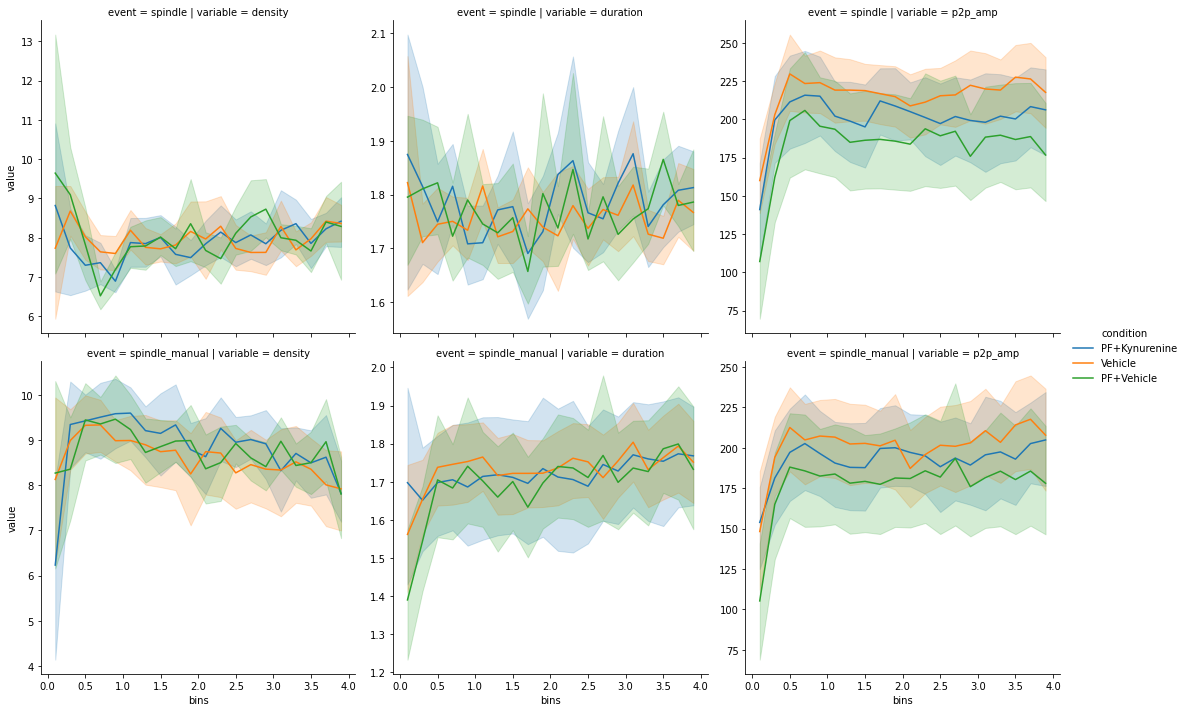

In [126]:
results_feat.loc[results_feat.condition == "Vehicle 1", "condition"] = "Vehicle"
results_feat.loc[results_feat.condition == "Vehicle 2", "condition"] = "Vehicle"
results_feat.loc[results_feat.condition == "Intermittent 1", "condition"] = "Intermittent"
results_feat.loc[results_feat.condition == "Intermittent 2", "condition"] = "Intermittent"
results_feat = results_feat[results_feat.condition != "Intermittent"]
results_feat = results_feat[results_feat.variable != "count"]
sns.relplot(data=results_feat.reset_index(), x='bins', y='value', 
            row="event", hue="condition", col="variable", 
            kind="line", facet_kws={"sharey": False})

In [127]:
df_spin_feat = get_spin_feat_df(df_perf, file_pattern="{animal}_{condition}_spin_feat.csv")
df_spin_feat = df_spin_feat.rename(columns={"event": "scoring"})
df_spin_feat.loc[df_spin_feat.scoring == "spindle", "scoring"] = "automated"
df_spin_feat.loc[df_spin_feat.scoring == "spindle_manual", "scoring"] = "manual"
df_spin_feat.loc[df_spin_feat.condition == "Vehicle 1", "condition"] = "Vehicle"
df_spin_feat.loc[df_spin_feat.condition == "Vehicle 2", "condition"] = "Vehicle"
df_spin_feat.loc[df_spin_feat.condition == "Intermittent 1", "condition"] = "Intermittent"
df_spin_feat.loc[df_spin_feat.condition == "Intermittent 2", "condition"] = "Intermittent"
df_spin_feat = df_spin_feat[df_spin_feat.condition != "Intermittent"]
df_spin_feat = df_spin_feat.drop(columns = df_spin_feat.loc[:, "10.0":"15.0"].columns)

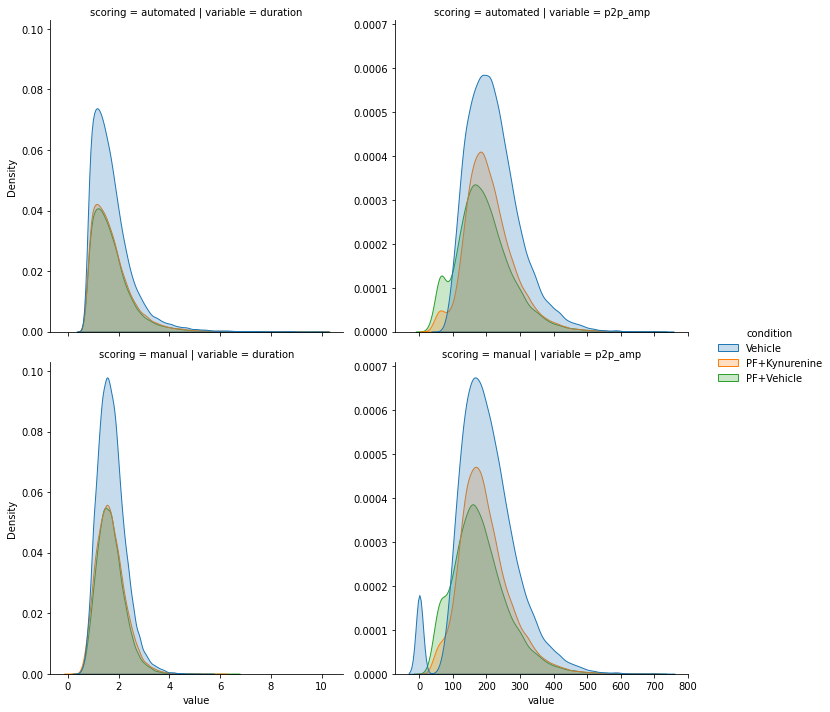

In [128]:
sns.displot(data=df_spin_feat.melt(id_vars=["condition", "scoring"], value_vars=["duration", "p2p_amp"]),
            col="variable", hue="condition", row="scoring", x="value", 
            fill=True, kind="kde", facet_kws={"sharex": "col", "sharey": "col"})

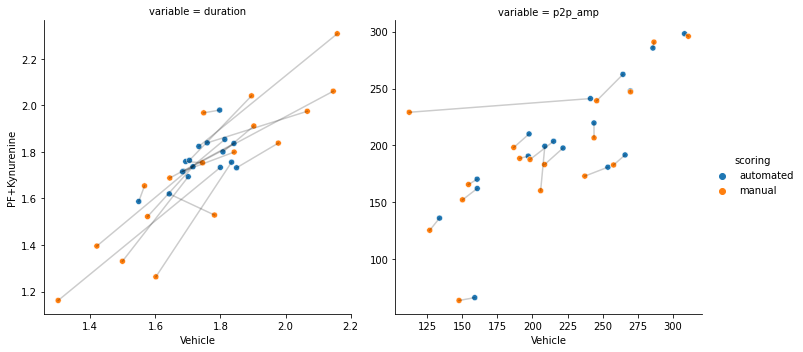

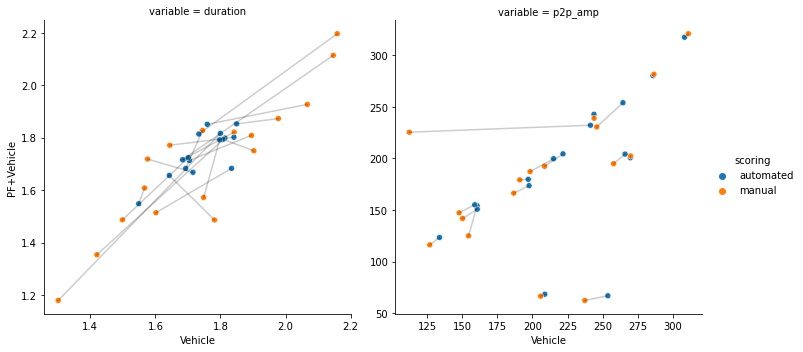

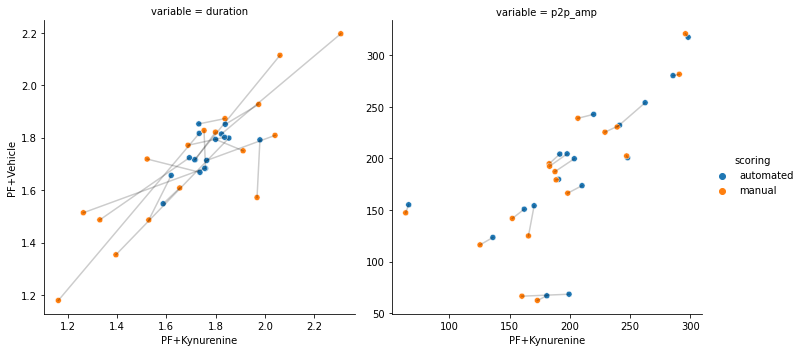

In [129]:
tmp = df_spin_feat.melt(id_vars=["condition", "scoring", "animal"], value_vars=["duration", "p2p_amp"])
tmp = tmp.groupby(["animal", "variable", "condition", "scoring"]).mean().reset_index()
tmp = tmp.pivot_table(index=["animal", "variable", "scoring"], columns=["condition"], values=["value"])["value"].reset_index()


for x, y in list(combinations(df_spin_feat.condition.unique(), 2)):

    g = sns.relplot(data=tmp, col="variable", hue="scoring", x=x, y=y, 
                    kind="scatter", facet_kws={"sharex": "col", "sharey": "col"})

    for ax, variable in zip(g.axes[0], ["duration", "p2p_amp"]):
        for animal in tmp.animal.unique():
            points = tmp.loc[(tmp.variable == variable) & (tmp.animal == animal), [x, y]].values        
            ax.plot(*points.T, alpha=0.2, color="k")


### t-tests

In [130]:
df = get_spin_feat_df(df_perf)

In [131]:
sleep_duration = get_sleep_duration_df(sleep_files)
clear_output()

In [132]:
res = get_stats(df, sleep_duration).reset_index()
res.loc[res.scoring == "spindle", "scoring"] = "automated"
res.loc[res.scoring == "spindle_manual", "scoring"] = "manual"

res.sort_values(["scoring", "feature", "condition"]).reset_index(drop=True)

,feature,condition,scoring,mean,std,count
0,density,PF+Kynurenine,automated,7.680852,0.562738,17
1,density,PF+Vehicle,automated,7.732376,0.526732,17
2,density,Vehicle,automated,7.676477,0.530724,17
3,duration,PF+Kynurenine,automated,1.761664,0.091797,17
4,duration,PF+Vehicle,automated,1.742812,0.081641,17
5,duration,Vehicle,automated,1.742382,0.081762,17
6,p2p_amp,PF+Kynurenine,automated,203.759420,55.825701,17
7,p2p_amp,PF+Vehicle,automated,188.703221,67.304114,17
8,p2p_amp,Vehicle,automated,221.861158,49.526508,17
9,density,PF+Kynurenine,manual,9.089783,1.007393,17


In [134]:
p_val_res = get_pvalues(df, sleep_duration, event_kinds=("spindle", "spindle_manual"))
p_val_res.loc[p_val_res.scoring == "spindle", "scoring"] = "automated"
p_val_res.loc[p_val_res.scoring == "spindle_manual", "scoring"] = "manual"

p_val_res.sort_values(["scoring", "feature"]).reset_index(drop=True)

,scoring,feature,t-value,p-value,N,condition1,condition2
0,automated,density,-0.641367,0.530365,17,PF+Kynurenine,PF+Vehicle
1,automated,density,0.048595,0.961844,17,PF+Kynurenine,Vehicle
2,automated,density,0.787260,0.442636,17,PF+Vehicle,Vehicle
3,automated,duration,1.116703,0.280611,17,PF+Kynurenine,PF+Vehicle
4,automated,duration,1.136237,0.272590,17,PF+Kynurenine,Vehicle
5,automated,duration,0.033868,0.973401,17,PF+Vehicle,Vehicle
6,automated,p2p_amp,1.245929,0.230726,17,PF+Kynurenine,PF+Vehicle
7,automated,p2p_amp,-2.421890,0.027685,17,PF+Kynurenine,Vehicle
8,automated,p2p_amp,-2.568384,0.020622,17,PF+Vehicle,Vehicle
9,manual,density,0.716415,0.484062,17,PF+Kynurenine,PF+Vehicle


# Whole recording analyses

In [160]:
study_no = 1
root_path = Path(f"/Users/christian/Library/CloudStorage/OneDrive-UniversityofSouthCarolina/Data/Ana_paper/Sleep Study #{study_no}/")

def file_list_to_dict_whole(files):
    keys = [path.parent.parent.name for path in files]
    return dict(zip(keys, files))

edf_files = file_list_to_dict(list(root_path.glob("*/*.edf")))
spindle_files = file_list_to_dict(list(root_path.glob("*/*Spindle Marker Grid Start End*.xls*")))
sleep_files = file_list_to_dict(list(root_path.glob("*/*Marker Grid Sleep and Spindles with Timestamp*.xls*")))

whole_edf_files = file_list_to_dict_whole(list(root_path.glob("*/*/*.edf")))
whole_sleep_files = file_list_to_dict_whole(list(root_path.glob("*/*/*.xls*")))
whole_sleep_files.update(file_list_to_dict_whole(list(root_path.glob("*/*/*.csv"))))
len(whole_sleep_files)

# missing: 1 Female 8- 17; 2 Female 8-17; 3 Female 5-16; 3 Male 8-17; 4 Male 8-17; 5 Female 9-17; 7 Male 9-17

19

In [161]:
recompute = False
file_name = Path("whole_recording_start_times.csv")

if recompute or not file_name.exists():
    start_times = get_start_times(whole_edf_files, edf_files)
    pd.Series(list(start_times.values()), index=start_times.keys()).to_csv(file_name)
else:
    start_times = pd.read_csv(file_name)
    start_times.columns = ["animal", "condition", "start_time"]
    start_times = start_times.set_index(["animal", "condition"])["start_time"]

In [162]:
recompute = False
results_feat = []
for animal, edf_file in tqdm(list(whole_edf_files.items())):
    for condition in ["baseline", "kynurenine"]:
        file_name = Path(f"{animal}_{condition}_whole.csv")
        if recompute or not file_name.exists():
            ch_name = df_perf.set_index(["animal", "condition"]).loc[(animal, condition), "ch_name"]
            cropped_raw = get_whole_raw(edf_file, condition, animal)

            spin_annotations = get_spindles_annotations(cropped_raw, ch_name=ch_name)
            annotations_stages = get_sleep_stages(edf_file, cropped_raw)

            spin_annotations = filter_annots_per_stage(spin_annotations, annotations_stages)

            cropped_raw.set_annotations(spin_annotations + annotations_stages)

            res, spin_feat = get_plotting_data(cropped_raw, ch_name, nb_hours=12, bins_per_hours=1,
                                               event_kinds=("spindle",))

            res["animal"] = animal
            res["condition"] = condition
            res.to_csv(file_name)
            spin_feat.to_csv(Path(f"{animal}_{condition}_spin_feat_whole.csv"))
        else:
            res = pd.read_csv(file_name, index_col=0)
        results_feat.append(res)

results_feat = pd.concat(results_feat)

  0%|          | 0/13 [00:00<?, ?it/s]

In [163]:
#sns.relplot(data=results_feat.reset_index(), x='bins', y='value', 
#            row="event", hue="condition", col="variable", 
#            kind="line", facet_kws={"sharey": False})

In [164]:
df_perf = get_perf_df(study_no, edf_files, sleep_files, spindle_files)
df = get_spin_feat_df(df_perf, file_pattern="{animal}_{condition}_spin_feat_whole.csv")

In [165]:
recompute = False
file_name = Path("whole_recording_binned_nrem.csv")

if recompute or not file_name.exists():
    df_perf = get_perf_df(1, edf_files, sleep_files, spindle_files)
    ch_names = df_perf.set_index(["animal", "condition"])["ch_name"]
    bins = np.arange(0, 60*60*12+1, 60*60)

    nrem_durations = []
    for animal in tqdm(list(whole_edf_files)):
        for condition in ["baseline", "kynurenine"]:
            raw = get_whole_raw(whole_edf_files[animal], condition, animal, 
                                start_times, ch_names[animal])
            stage_df = get_sleep_stages_df(whole_sleep_files[animal], raw, stage_duration=10.0)
            
            for start, stop in zip(bins[:-1], bins[1:]):
                tmp = stage_df[(stage_df.start >= start) & (stage_df.start < stop)]
                nrem_durations.append({"animal": animal, "condition": condition, "start": start, 
                                    "stop": stop, "nrem_min":np.sum(tmp["label"] == "S")/6})
            
    sleep_duration = pd.DataFrame(nrem_durations)
    sleep_duration.to_csv(file_name)
else:
    sleep_duration = pd.read_csv(file_name, index_col=0)


In [166]:
bins = np.arange(0, 60*60*12+1, 60*60)
binned_res = []
for start, stop in tqdm(zip(bins[:-1], bins[1:])):
    res = get_stats_ind(df[(df.onset >= start) & (df.onset < stop)], 
                    sleep_duration[sleep_duration.start == start].set_index(["animal", "condition"]),
                    event_kinds=("spindle", ))
    res["time"] = (start + stop)/2
    binned_res.append(res)

binned_res = pd.concat(binned_res)
binned_res.time /= 60*60
binned_res = binned_res.drop(columns=["scoring"]).reset_index(drop=True)


0it [00:00, ?it/s]

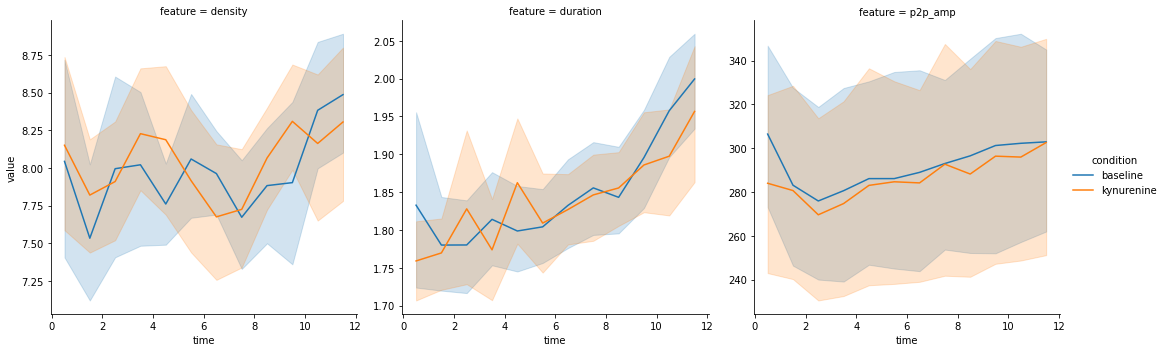

In [167]:
sns.relplot(data=binned_res, 
            x='time', y='value', 
            hue="condition", col="feature", 
            kind="line", facet_kws={"sharey": False})

In [168]:
res = get_stats(df, sleep_duration.groupby(["animal", "condition"]).sum(), 
                event_kinds=("spindle",)).reset_index()

res.loc[res.scoring == "spindle", "scoring"] = "automated"
res.loc[res.scoring == "spindle_manual", "scoring"] = "manual"

res.sort_values(["scoring", "feature", "condition"]).reset_index(drop=True)

,feature,condition,scoring,mean,std,count
0,density,baseline,automated,7.919833,0.614994,13
1,density,kynurenine,automated,7.966235,0.554602,13
2,duration,baseline,automated,1.830700,0.099245,13
3,duration,kynurenine,automated,1.819736,0.095460,13
4,p2p_amp,baseline,automated,289.504141,78.531457,13
5,p2p_amp,kynurenine,automated,285.484389,85.017521,13


In [169]:
p_val_res = get_pvalues(df, sleep_duration.groupby(["animal", "condition"]).sum(), 
            event_kinds=("spindle",))

p_val_res.loc[p_val_res.scoring == "spindle", "scoring"] = "automated"
p_val_res.loc[p_val_res.scoring == "spindle_manual", "scoring"] = "manual"

p_val_res.sort_values(["scoring", "feature"]).reset_index(drop=True)


,scoring,feature,t-value,p-value,N,condition1,condition2
0,automated,density,-0.887296,0.392356,13,baseline,kynurenine
1,automated,duration,1.259787,0.231697,13,baseline,kynurenine
2,automated,p2p_amp,0.992609,0.340495,13,baseline,kynurenine
